# Metadata Collation for TCGA and GTEx

Goal: Create a combined metadata table that spans both TCGA and GTEx. 

TSVs were obtained from [here](http://snaptron.cs.jhu.edu/data), and publically rehosted on Synapse.

- TCGA: syn7248855
- GTEx: syn10142937

In [2]:
%matplotlib inline
import os
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set_style('whitegrid')

## Read Inputs

In [3]:
tcga = pd.read_csv('input_data/tcga-sample-metadata.tsv', sep='\t', low_memory=False)
gtex = pd.read_csv('input_data/gtex-sample-metadata.tsv', sep='\t')

How many metadata columns are there?

In [4]:
print 'TCGA: {}\t GTEx: {}'.format(len(tcga.columns), len(gtex.columns))

TCGA: 858	 GTEx: 301


...that's quite a few. Because most columns are likely uninformative, filter the samples by RNA-Seq and examine the remaining columns.

## TCGA
Locate what column the sample barcodes are in

In [10]:
tcga[tcga.apply(lambda r: r.str.contains('TCGA-DQ-5630', case=False).any(), axis=1)].index

Int64Index([2470], dtype='int64')

Locate column(s) to filter by

In [6]:
print [str(x) for x in tcga.iloc[2470]].index('RNA-Seq')

33


In [7]:
tcga.columns[126]  # "Barcode" in original metadata

'gdc_cases.samples.portions.analytes.aliquots.submitter_id'

In [8]:
tcga.columns[33]  # We want to filter samples by this column using the term: 'RNA-Seq'

'gdc_experimental_strategy'

Subset by experimental strategy

In [13]:
tcga = tcga[tcga['gdc_experimental_strategy'] == 'RNA-Seq']
print 'Samples: {}\tFeatures: {}'.format(*tcga.shape)

Samples: 11284	Features: 858


Sift through 858 columns using the famous GSD (Graduate Student Descent) algorithm

### List of columns to keep for TCGA metadata

Sample Information

- gdc_cases.samples.submitter_id	
- reads_downloaded
- paired_end
- mapped_read_count
- auc
- gdc_platform
- gdc_file_size
- gdc_experimental_strategy
- gdc_center.code
- gdc_center.name	
- gdc_center.short_name
- gdc_data_category
- gdc_cases.tissue_source_site.name
- gdc_cases.samples.portions.analytes.aliquots.concentration
- gdc_cases.samples.portions.analytes.a260_a280_ratio
- cgc_sample_country_of_sample_procurement

Patient Information

- gdc_cases.demographic.gender
- gdc_cases.demographic.year_of_birth
- gdc_cases.demographic.race
- gdc_cases.demographic.ethnicity
- gdc_cases.samples.initial_weight
- gdc_cases.diagnoses.days_to_death
- gdc_cases.diagnoses.age_at_diagnosis
- gdc_cases.exposures.cigarettes_per_day	
- gdc_cases.exposures.alcohol_history
- gdc_cases.exposures.weight
- gdc_cases.exposures.years_smoked
- gdc_cases.exposures.height
- cgc_case_year_of_diagnosis

Tumor Information

- gdc_cases.project.name
- gdc_cases.project.primary_site
- gdc_cases.diagnoses.tumor_stage
- gdc_cases.diagnoses.vital_status
- gdc_cases.samples.sample_type
- cgc_case_new_tumor_event_after_initial_treatment
- cgc_case_pathologic_stage

Select, subset, and rename dataframe

In [14]:
tcga = tcga[['gdc_cases.samples.submitter_id', 'reads_downloaded', 'paired_end', 
             'mapped_read_count', 'auc', 'gdc_platform', 'gdc_file_size', 
             'gdc_experimental_strategy', 'gdc_center.short_name', 
             'gdc_data_category', 'gdc_cases.tissue_source_site.name', 
             'gdc_cases.samples.portions.analytes.aliquots.concentration', 
             'gdc_cases.samples.portions.analytes.a260_a280_ratio', 
             'cgc_sample_country_of_sample_procurement', 'gdc_cases.demographic.gender',
             'gdc_cases.demographic.year_of_birth', 'gdc_cases.demographic.race', 
             'gdc_cases.demographic.ethnicity', 'gdc_cases.samples.initial_weight', 
             'gdc_cases.diagnoses.days_to_death', 'gdc_cases.diagnoses.age_at_diagnosis',
             'gdc_cases.exposures.cigarettes_per_day', 
             'gdc_cases.exposures.alcohol_history', 'gdc_cases.exposures.weight', 
             'gdc_cases.exposures.years_smoked', 'gdc_cases.exposures.height', 
             'cgc_case_year_of_diagnosis', 'gdc_cases.project.name', 
             'gdc_cases.project.primary_site', 'gdc_cases.diagnoses.tumor_stage', 
             'gdc_cases.diagnoses.vital_status', 'gdc_cases.samples.sample_type',
             'cgc_case_new_tumor_event_after_initial_treatment', 
             'cgc_case_pathologic_stage']]
tcga.index = tcga['gdc_cases.samples.submitter_id']
tcga.columns = ['submitter_id', 'reads_downloaded', 'paired_end', 'mapped_read_count', 
                'auc', 'platform', 'file_size', 'experimental_strategy', 
                'center_short', 'data_category', 'tissue_source_site', 
                'aliquots_concentration', 'a260_a280_ratio', 'country_of_sample_procurement', 
                'gender', 'year_of_birth', 'race', 'ethnicity', 'initial_weight', 
                'days_to_death', 'age_at_diagnosis', 'cigarettes_per_day', 'alcohol_history',
                'weight', 'years_smoked', 'height', 'year_of_diagnosis', 'project_name',
                'primary_site', 'tumor_stage', 'vital_status', 'sample_type',
                'new_tumor_event_after_initial_treatment', 'pathologic_stage']
tcga.index = tcga['submitter_id']
tcga.index.name = None

Drop duplicate rows based on index

In [15]:
tcga = tcga[~tcga.index.duplicated(keep='first')]

In [16]:
print 'Samples: {}\tFeatures: {}'.format(*tcga.shape)

Samples: 11190	Features: 34


#### Data Cleanup

Look for features with values that need NAN replacements, sparse / uninformative, etc

In [18]:
for c in tcga.columns:
    print c, len(tcga[c].unique())
    if len(tcga[c].unique()) == 1:
        print '\tdropping: ' + c + '\t' + str(tcga[c][0])
        tcga.drop(c, axis=1, inplace=True)

submitter_id 11190
reads_downloaded 11189
paired_end 1
	dropping: paired_end	True
mapped_read_count 11190
auc 11190
platform 2
file_size 11190
experimental_strategy 1
	dropping: experimental_strategy	RNA-Seq
center_short 3
data_category 1
	dropping: data_category	Raw sequencing data
tissue_source_site 217
aliquots_concentration 19
a260_a280_ratio 108
country_of_sample_procurement 33
gender 3
year_of_birth 91
race 7
ethnicity 4
initial_weight 221
days_to_death 1579
age_at_diagnosis 7797
cigarettes_per_day 186
alcohol_history 3
weight 379
years_smoked 64
height 135
year_of_diagnosis 34
project_name 33
primary_site 26
tumor_stage 21
vital_status 4
sample_type 7
new_tumor_event_after_initial_treatment 3
pathologic_stage 21


convert string nones to nans

In [19]:
tcga.replace('not reported', np.nan, inplace=True)
tcga.replace('None', np.nan, inplace=True)

In [22]:
tcga.to_csv('tcga-metadata-cleaned.tsv', sep='\t')

## Combined Columns

Metadata that spans both datasets

- ID
    - submitter_id
    - SAMPID
- Reads
    - reads_downloaded
    - spots (??)
- size
    - file_size (bytes?, divide by a million)
    - size_MB
- platform
    - platform
    - Model
- sex
    - gender
    - Sex
- tissue
    - primary_site
    - Body_Site
- Sequencing
    - center_short
    - CenterName 
- weight
    - weight
    - WGHT
- height
    - height
    - HGHT
- mapped
    - mapped_read_count
    - SMMPPD
- race
    - race
    - RACE (3=white, 2=african american, 1=asian, 98,98,4=other)
- age
    - year_of_birth (2010 - year_of_birth = age)
    - AGE
- ethnicity
    - ethnicity
    - ETHNICITY (don't know code) 
- qc (Need transformation factor)
    - a260_a280_ratio
    - SMRIN

Fix A260 / a280 ratios. Two samples have a260's greater than 10 (180 and 187.5 respectively). We'll set these to NaN since we don't actually know their score should be.

In [23]:
for i in tcga[tcga['a260_a280_ratio'] > 10].index:
    tcga.loc[i, 'a260_a280_ratio'] = np.nan

Create combined dataframe

In [33]:
colnames = ['id', 'reads', 'size_MB', 'platform', 'sex', 'tissue', 'seq_site', 'weight', 
            'height', 'mapped_reads', 'race', 'age', 'qc']

tcga_sub = tcga[['submitter_id', 'reads_downloaded', 'file_size', 'platform', 'gender', 
                 'primary_site','center_short', 'weight', 'height', 'mapped_read_count',
                 'race', 'year_of_birth', 'a260_a280_ratio']]
tcga_sub.columns = colnames

gtex_sub = gtex[['SAMPID', 'spots', 'size_MB', 'Model', 'Sex', 'Body_Site', 'CenterName', 
                 'WGHT', 'HGHT', 'SMMPPD', 'RACE', 'AGE', 'SMRIN']]
gtex_sub.columns = colnames

# TCGA A280 conversion to RIN space
# Model as a piecewise linear transformation. 
# For values <=2.0    y = 20x - 30
# For values >2.0     y = -20x + 50
vals = []
for v in tcga_sub.qc:
    if v <= 2.0:
        vals.append(20*v - 30)
    else:
        vals.append(-20*v + 50)
tcga_sub.qc = [x if x > 0 else 0 for x in vals]

# Convert TCGA height from cm to in
tcga_sub.height = tcga_sub.height.apply(lambda x: x*1.0 / 2.54)
# Fix outliers
tcga_sub.height = [x if x > 40 else np.nan for x in tcga_sub.height]

# Convert size to MB for TCGA
tcga_sub.size_MB = tcga_sub.size_MB.apply(lambda x: (x*1.0) / 1024 / 1024)

# Convert year of birth to age
tcga_sub.age = tcga_sub.age.apply(lambda x: 2010 - x)

# Truncate last letter of TCGA ID
tcga_sub['id'] = tcga_sub.id.apply(lambda x: x[:-1])

# Create combined manifest
df = pd.concat([tcga_sub, gtex_sub], axis=0)

# Add dataset column
df['dataset'] = ['tcga' if x.startswith('TCGA') else 'gtex' for x in df['id']]

# Add Tumor column
df['tumor'] = ['no' if x.endswith('-11') or x.startswith('GTEX') 
               else 'yes' for x in df['id']]

# Clean values for certain columns
df.platform.replace('Illumina HiSeq 2000', 'Illumina HiSeq', inplace=True)

# Generalize tissue labels
df.tissue = df.tissue.apply(lambda x: x.split()[0])
df.tissue.replace('Small', 'Small_intestine', inplace=True)
df.tissue.replace('Soft', 'Soft_tissue', inplace=True)
df.tissue.replace('Bone', 'Bone_marrow', inplace=True)
df.tissue.replace('Colorectal', 'Colon', inplace=True)

# Replace numbers with string words
df.race.replace(3, 'white', inplace=True)
df.race.replace(2, 'black or african american', inplace=True)
df.race.replace(1, 'asian', inplace=True)
df.race.replace(98, 'other', inplace=True)
df.race.replace(99, 'other', inplace=True)
df.race.replace(4, 'other', inplace=True)

# Set index to ID column
df.index = df['id']
df.index.name = None

# Create "Type" label. Disease for tcga and long form label for GTEx
types = []
for sample in df.index:
    if sample.startswith('TCGA'):
        types.append('_'.join(
                tcga[tcga.submitter_id.str.contains(sample)].project_name[0].split()))
    else:
        types.append('_'.join(
                list(gtex_sub[gtex_sub['id'] == sample].tissue)[0].replace(
                    '-', '').split()))
df['type'] = types

# Save
df.to_csv('tcga-gtex-metadata-intersect.tsv', sep='\t')

/Users/Jvivian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
pd.set_option('max_columns', 4)
df.head()

,id,reads,...,tumor,type
TCGA-CD-8534-01,TCGA-CD-8534-01,240016440,...,yes,Stomach_Adenocarcinoma
TCGA-ER-A19A-06,TCGA-ER-A19A-06,179705496,...,yes,Skin_Cutaneous_Melanoma
TCGA-C5-A1M8-01,TCGA-C5-A1M8-01,195313702,...,yes,Cervical_Squamous_Cell_Carcinoma_and_Endocervical_Adenoc...
TCGA-D1-A0ZN-01,TCGA-D1-A0ZN-01,30911468,...,yes,Uterine_Corpus_Endometrial_Carcinoma
TCGA-EM-A4FF-01,TCGA-EM-A4FF-01,206307190,...,yes,Thyroid_Carcinoma


## Missing Data


In [29]:
df.isnull().sum()

id                 0
reads              0
size_MB            0
platform           0
sex               39
tissue             0
seq_site           0
weight          8342
height          8428
mapped_reads    1048
race            1373
age              210
qc                 0
dataset            0
tumor              0
type               0
dtype: int64

In [82]:
print 'Number of samples with missing values: {} of {}'.format(
    sum(df.isnull().sum(axis=1) > 0), df.shape[0])

Number of samples with missing values: 9544 of 20852


# Plots

In [ ]:
gr = df.columns.to_series().groupby(df.dtypes).groups
gr = {k.name: v for k, v in gr.items()}

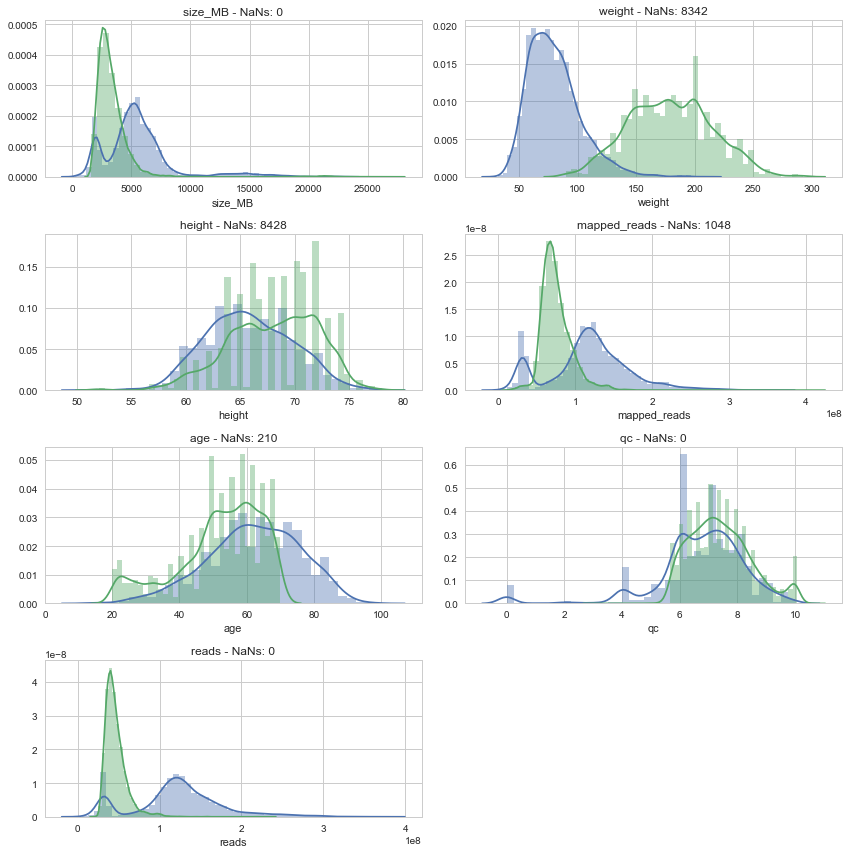

In [189]:
f, ax = plt.subplots(4, 2)
ax = ax.flatten()
i = 0
for s in gr['float64'] + gr['int64']:
    n = sum(df[s].value_counts())
    title = s + ' - NaNs: {}'.format(df.shape[0] - n)
    fg = sns.FacetGrid(df.dropna(), hue='dataset')
    fg = fg.map(sns.distplot, s, ax=ax[i])
    ax[i].set_title(title)
    i += 1
    plt.close(fg.fig)  # FacetGrid makes its own plot we don't want
ax[-1].axis('off')
f.subplots_adjust(hspace=.5)
plt.tight_layout()
plt.show()

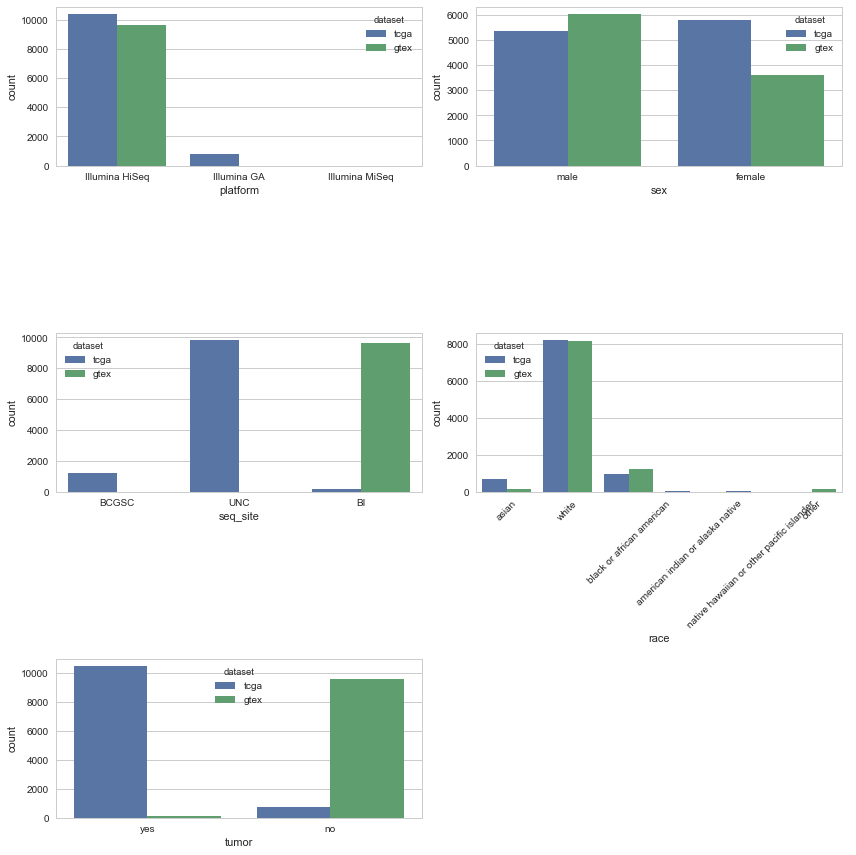

In [217]:
f, ax = plt.subplots(3, 2)
ax = ax.flatten()
for i, s in enumerate(['platform', 'sex', 'seq_site', 'race', 'tumor']):
    n = sum(df[s].value_counts())
    title = s + ' - NaNs: {}'.format(df.shape[0] - n)
    sns.countplot(data=df, x=s, hue='dataset', ax=ax[i])
plt.setp(ax[3].get_xticklabels(), rotation=45)
plt.tight_layout()
ax[-1].axis('off')
plt.show()

# Bokeh Plots

Bokeh renders to HTML / JS and therefore is not exportable by Jupyter to LaTeX. These plots are more aesthetic and 
will be featured on the author's website. 

In [111]:
from bokeh.charts import Bar, Histogram
from bokeh.io import output_notebook, show, gridplot
from bokeh.resources import CDN
from bokeh.embed import autoload_static

output_notebook()

Loading BokehJS ...

Create groups by datatype of columns

### Continuous Data

In [151]:
p = []
for s in gr['float64'] + gr['int64']:
    n = sum(df[s].value_counts())
    title = s + ' - NaNs: {}'.format(df.shape[0] - n)
    p.append(Histogram(df.dropna(), s, title=title, width=350,
                      color='dataset'))

g = gridplot([[p[0], p[1]], [p[2], p[3]], [p[4], p[5]], [p[6], None]])
show(g)

js, tag = autoload_static(g, CDN, "js/bokeh/metadata-con.js")
with open("metadata-con.js", 'w') as f:
    f.write(js)
with open("tags", 'w') as f:    
    f.write(tag)

### Categorical Data

In [152]:
tooltips=[('# Samples', '@height')]

b1 = Bar(df, label='platform', group='dataset', width=350, tooltips=tooltips)
b2 = Bar(df, label='sex', group='dataset', width=350, tooltips=tooltips)
b3 = Bar(df, label='seq_site', group='dataset', width=350, tooltips=tooltips)
b4 = Bar(df, label='race', group='dataset', width=350, tooltips=tooltips)
b5 = Bar(df, label='tumor', group='dataset', width=350, tooltips=tooltips)

g = gridplot([[b1, b2], [b3, b4], [b5, None]])

show(g)

js, tag = autoload_static(g, CDN, "js/bokeh/metadata-cat.js")
with open("metadata-cat.js", 'w') as f:
    f.write(js)
with open("tags", 'a') as f:    
    f.write(tag)